In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, normalize

In [2]:
data = pd.read_csv('../data/sales_train_evaluation.csv.zip')
cal = pd.read_csv('../data/calendar.csv', index_col=0)
all_sum = data.iloc[:,6:].sum().values
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(all_sum.reshape(-1, 1))

In [3]:
def sliding_windows(data, seq_length , train):
    if train:
        x = []
        y = []
        for i in range(len(data)-seq_length*2):
            _x = data[i:(i+seq_length)]
            _y = data[i+(seq_length*2)]
            x.append(_x)
            y.append(_y)
        return np.array(x),np.array(y)[:,0].reshape(-1,1)
    else:
        x = []
        for i in range(len(data)-seq_length+1):
            _x = data[i:(i+seq_length)]
            x.append(_x)
        return np.array(x)

In [4]:
seq_length = 28
x, y = sliding_windows(data, seq_length, True)
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))
trainX = Variable(torch.Tensor(np.array(x[0:-28])))
trainY = Variable(torch.Tensor(np.array(y[0:-28])))
valX = Variable(torch.Tensor(np.array(x[-28:])))
valY = Variable(torch.Tensor(np.array(y[-28:])))

In [5]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = 1
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)


    def forward(self, x):
        h_1 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device))
        c_1 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device))
        _, (hn, cn) = self.LSTM(x, (h_1, c_1))
        y = hn.view(-1, self.hidden_size)
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        out = self.fc(final_state)
        return out

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 200
learning_rate = 1e-3
input_size = x.shape[-1]
hidden_size = 512
num_layers = 3
num_classes = 1

In [7]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [8]:
for epoch in tqdm(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    
    optimizer.step()
    
    #Evaluate on test     
    lstm.eval()
    valid = lstm(valX.to(device))
    vall_loss = criterion(valid, valY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

  0%|          | 1/200 [00:00<01:22,  2.40it/s]

Epoch: 0, loss: 0.09134 valid loss:  0.15959 


 26%|██▌       | 51/200 [00:16<00:47,  3.12it/s]

Epoch: 50, loss: 0.04313 valid loss:  0.08478 


 50%|█████     | 101/200 [00:32<00:31,  3.11it/s]

Epoch: 100, loss: 0.03823 valid loss:  0.05902 


 76%|███████▌  | 151/200 [00:48<00:15,  3.08it/s]

Epoch: 150, loss: 0.01369 valid loss:  0.01641 


100%|██████████| 200/200 [01:04<00:00,  3.09it/s]


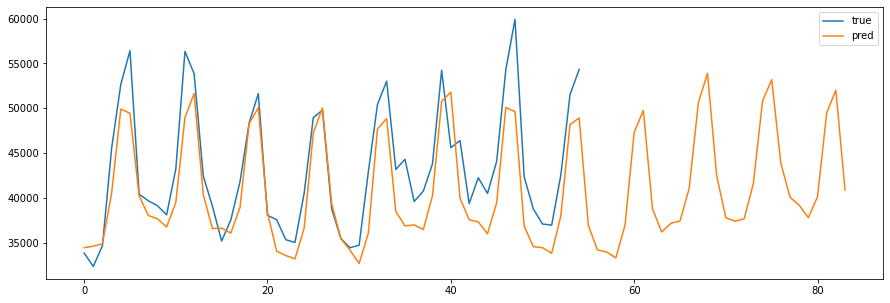

In [9]:
x = sliding_windows(data, seq_length, False)
testX = Variable(torch.Tensor(np.array(x)))
train_predict = lstm(testX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.figure(figsize=(15,5))
plt.plot(torch.arange(0, 55),dataY_plot[-28*2+1:],label='true')
plt.plot(torch.arange(0,28*3),data_predict[-28*3:],label='pred')
plt.legend()
plt.show()